In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('C:/Users/fu/Downloads/Apps/Git_Projects/kemal_tariffs/output/3-Stufen Auslösung optimiert/3-Stufen Auslösung optimiert_neu.csv', sep=';', encoding='latin-1')
prices = df['dynamic'].values
prices_reshaped = prices.reshape(365, 24)
prices_reshaped

array([[16.7220585, 17.2343535, 17.1843735, ..., 22.9895505, 23.110752 ,
        21.7413   ],
       [24.6039045, 23.8242165, 23.9816535, ..., 35.0697165, 34.2250545,
        32.889339 ],
       [33.6127995, 32.36205  , 32.207112 , ..., 33.7352505, 31.6460865,
        29.070867 ],
       ...,
       [17.36805  , 17.358054 , 17.333064 , ..., 17.997798 , 20.229405 ,
        19.7283555],
       [18.1040055, 17.7141615, 18.477606 , ..., 24.410232 , 23.628045 ,
        22.7696385],
       [21.933723 , 19.0261365, 17.86785  , ..., 18.11775  , 18.702516 ,
        17.672928 ]])

weekday filtered:  205
weekend filtered:  64
weekday:  [22.02053544 29.72646775 36.40693026]
weekend:  [20.04605026 28.45952023 34.22788255]


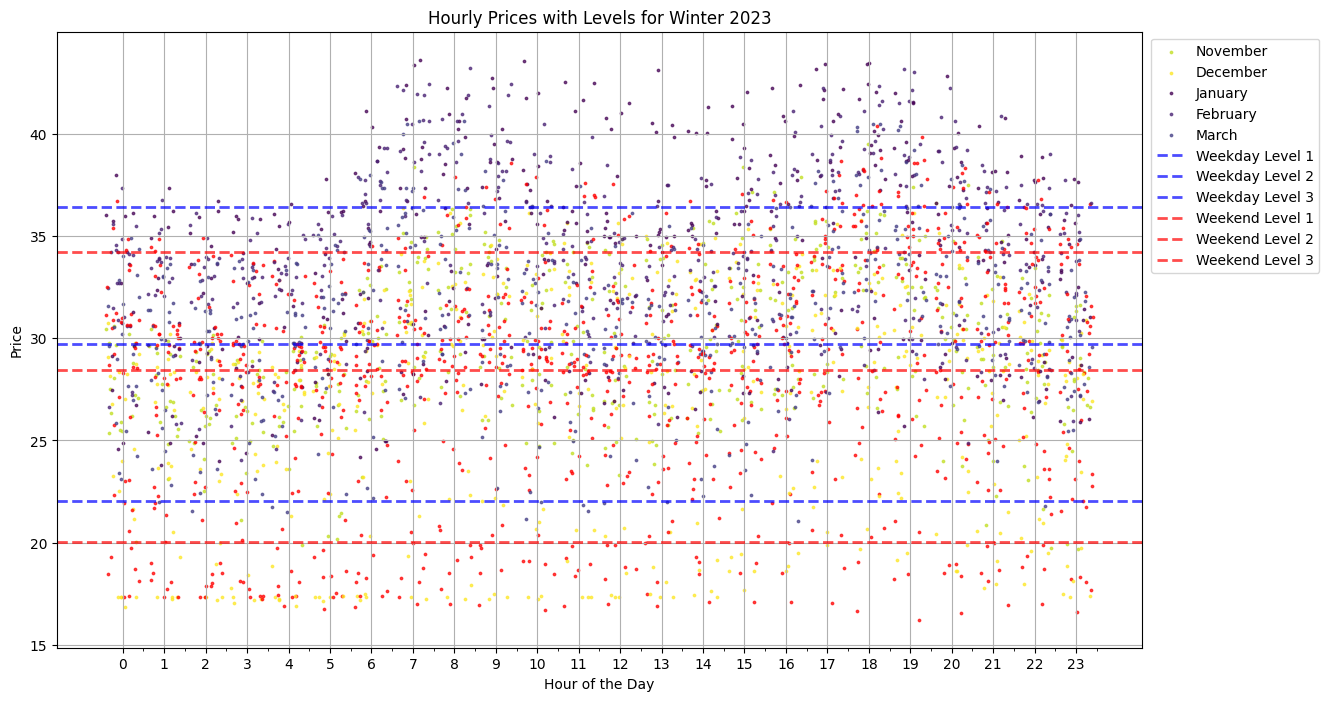

In [32]:
import calendar
dates = pd.date_range(start='2023-01-01', periods=365)
months = dates.month
weekdays = dates.weekday
month_names = [calendar.month_name[i] for i in range(1, 13)]
viridis_cmap = plt.get_cmap('viridis', 12)
unique_colors = viridis_cmap(np.linspace(0, 1, 12))

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
# def remove_outliers(data, threshold=1.5):
#     Q1 = np.percentile(data, 25)
#     Q3 = np.percentile(data, 75)
#     IQR = Q3 - Q1
#     return data[(data >= Q1 - threshold * IQR) & (data <= Q3 + threshold * IQR)]

def remove_outliers(data, n_clusters=1, distance_threshold=10):
    data_reshaped = data.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_reshaped)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    distances = cdist(data_reshaped, cluster_centers, 'euclidean')
    min_distances = np.min(distances, axis=1)

    is_outlier = min_distances > distance_threshold
    num_outliers = np.sum(is_outlier)  # Count the number of outliers
    filtered_data = data_reshaped[~is_outlier]
    #return data
    return filtered_data

def plot_season_with_clusters(months_group, season_name):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    all_weekday_prices = []
    all_weekend_prices = []
    all_weekday_hours = []
    all_weekend_hours = []

    weekday_filtered = 0
    weekend_filtered = 0
    for month in months_group:
        # Filter data for the current month
        month_mask = months == month
        prices_month = prices_reshaped[month_mask] # [[16, 17, 15, 23, ... (24 intotal)], [12, 23, 24,... ], ... (31 in total)]
        hours_month = np.tile(np.arange(24), sum(month_mask)) # [[0,1,2,3,...,23], [0,1,2,...,23], ... (31 in total)]
        prices_flat_month = prices_month.flatten() # [16, 17, 15, 23, ..., 35, 28] (24*31 in total)
        
        # Determine weekends
        weekends = weekdays[month_mask]
        weekends_repeated = np.repeat(weekends, 24)
        is_weekend = (weekends_repeated >= 5)
        
        # Collect data for clustering
        weekday_prices = prices_flat_month[~is_weekend]
        weekend_prices = prices_flat_month[is_weekend]
        
        # Remove outliers from both weekday and weekend prices
        weekday_prices_clean = remove_outliers(weekday_prices)
        weekend_prices_clean = remove_outliers(weekend_prices)
        
        all_weekday_prices.append(weekday_prices_clean)
        all_weekend_prices.append(weekend_prices_clean)
        
        hours_weekday = hours_month[~is_weekend]
        prices_weekday = prices_flat_month[~is_weekend]
        
        hours_weekend = hours_month[is_weekend]
        prices_weekend = prices_flat_month[is_weekend]
        
        hours_weekday_clean = hours_weekday[np.isin(prices_weekday, weekday_prices_clean)] 
        prices_weekday_clean = prices_weekday[np.isin(prices_weekday, weekday_prices_clean)] 
        
        hours_weekend_clean = hours_weekend[np.isin(prices_weekend, weekend_prices_clean)]
        prices_weekend_clean = prices_weekend[np.isin(prices_weekend, weekend_prices_clean)]

        weekday_filtered += len(prices_weekday) - len(prices_weekday_clean)
        weekend_filtered += len(prices_weekend) - len(prices_weekend_clean)

        # Apply jitter to clean data points
        hours_weekday_jittered = hours_weekday_clean + np.random.uniform(-0.4, 0.4, len(hours_weekday_clean))
        hours_weekend_jittered = hours_weekend_clean + np.random.uniform(-0.4, 0.4, len(hours_weekend_clean))
        
        # Plot weekdays with the unique color for the current month
        ax.scatter(hours_weekday_jittered, prices_weekday_clean, c=[unique_colors[month-1]], alpha=0.7, s=3, label=month_names[month-1])
        
        # Plot weekends in red
        ax.scatter(hours_weekend_jittered, prices_weekend_clean, c='red', alpha=0.7, s=3, label='_nolegend_')

    print('weekday filtered: ', weekday_filtered)
    print('weekend filtered: ', weekend_filtered)
    
    # Prepare data for clustering
    all_weekday_prices = np.concatenate(all_weekday_prices) # 1-D, length 1390
    all_weekend_prices = np.concatenate(all_weekend_prices)
    
    # get statistic data
    # print('Standard Deviation clean weekday: ', np.std(all_weekday_prices))
    # print('Standard Deviation clean weekend: ', np.std(all_weekend_prices))
    # print('Standard Deviation clean total: ', np.std(np.concatenate([all_weekday_prices, all_weekend_prices])))
    
    # Reshape prices for clustering
    weekday_prices_reshaped = np.tile(all_weekday_prices, (24, 1)).T # 2-D, make the 1-D data in days (every 24 data together)
    weekend_prices_reshaped = np.tile(all_weekend_prices, (24, 1)).T

    weekday_prices_reshaped_clean = remove_outliers(weekday_prices_reshaped)
    weekend_prices_reshaped_clean = remove_outliers(weekend_prices_reshaped)
    
    # Apply K-means clustering
    kmeans_weekday = KMeans(n_clusters=3, random_state=0).fit(weekday_prices_reshaped.reshape(-1, 1)) # without outlier removal again! (same result)
    kmeans_weekend = KMeans(n_clusters=3, random_state=0).fit(weekend_prices_reshaped.reshape(-1, 1))
    
    # Get cluster centers
    weekday_centers = np.sort(kmeans_weekday.cluster_centers_.flatten()) # (18, 18, 18, ... , 22, 22, 22, ..., 30, 30, 30) 24*3 elements in total
    print('weekday: ', weekday_centers)
    weekend_centers = np.sort(kmeans_weekend.cluster_centers_.flatten())
    print('weekend: ', weekend_centers)
    
    # Plot cluster centers for weekdays
    for i, center in enumerate(weekday_centers):
        ax.axhline(y=center, color='blue', alpha=0.7, linewidth=2, linestyle='--', label=f'Weekday Level {i+1}')
    
    # Plot cluster centers for weekends
    for i, center in enumerate(weekend_centers):
        ax.axhline(y=center, color='red', alpha=0.7, linewidth=2, linestyle='--', label=f'Weekend Level {i+1}')
    
    # Set labels and title
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Price')
    ax.set_title(f'Hourly Prices with Levels for {season_name} 2023')
    ax.set_xticks(np.arange(24))
    ax.set_xticks(np.arange(24) + 0.5, minor=True)  # Add minor ticks for better separation
    ax.grid(True)
    ax.legend(loc='upper right', bbox_to_anchor=(1.17, 1))
    
    # Save the plot as an image
    #plt.savefig(r'C:/Users/fu/Downloads/Dokumente/Smart Tariffe/TG/Datenanalyse/TG_Datenanalyser/Pictures/price levels/' + 'Levels for ' + f'{season_name}_2023.png',\
       #        bbox_inches='tight')
    plt.show()

spring_summer_months = [4, 5, 6, 7, 8, 9, 10]
winter_months = [11, 12, 1, 2, 3]
single_month = [3]
#plot_season_with_clusters(spring_summer_months, 'Summer')
plot_season_with_clusters(winter_months, 'Winter')
#plot_season_with_clusters(single_month, 'Month_' + f'{single_month[0]}')